In [1]:
import numpy as np
import torch

import gpytorch

from botorch.models import FixedNoiseGP, SingleTaskGP, HeteroskedasticSingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


from botorch.optim import optimize_acqf
import cma
from botorch.optim.fit import fit_gpytorch_torch
from scipy.optimize import minimize

from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
import time
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples

# import sys
# sys.path.insert(1, '/Users/trongduong/Dropbox/URP project/Code/PQC_composer')

# import qc_embedding
# from QuOTMANN import optimal_transport


from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(dim=6,negate=True)


In [27]:
class FirstSincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    has_lengthscale = False

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        #x1 = x1.div(self.lengthscale)
        #x2 = x2.div(self.lengthscale)
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20).to(x1))
        # return sinc(diff) = sin(diff) / diff
        K = torch.sin(diff).div(diff)
        
        print('x1: ', x1)
        print('x2: ', x2)
        print(x1.shape, x2.shape, K.shape, type(K))
        print('kernel: ', K)
        return K

In [31]:
class QNN_BO():
    def __init__(self, num_qubits, MAX_OP_NODES, N_TRIALS, N_BATCH, BATCH_SIZE, MC_SAMPLES, device=None, dtype=None):
        self.num_qubits = num_qubits
        self.MAX_OP_NODES = MAX_OP_NODES
        self.encoding_length = (self.num_qubits + 1) * self.MAX_OP_NODES

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = dtype or torch.double

        self.N_TRIALS = N_TRIALS
        self.N_BATCH = N_BATCH
        self.BATCH_SIZE = BATCH_SIZE
        self.MC_SAMPLES = MC_SAMPLES


    ## PROBLEM SETUP
    def obj_func(self, X):
        """Feasibility weighted objective"""
        print('query f: ', X)
#         latent_func_values = []
#         for enc in X.detach().numpy():
#             qc = self.vec_to_circuit(vec=enc)
#             latent_func_values.append(self.latent_func(qc))
#         return latent_func_values
        Y = neg_hartmann6(X)
        return Y

    def latent_func(self,circuit):
        f = circuit.num_parameters #/ self.MAX_OP_NODES
        return torch.as_tensor(f, device=self.device, dtype=self.dtype)

    def vec_to_circuit(self,vec):
        qc = qc_embedding.enc_to_qc(num_qubits=self.num_qubits, encoding=vec)
        #print(qc.draw())
        return qc

    ## MODEL INITIALIZATION
    def generate_initial_data(self, n):
        # generate training data

        #train_x = torch.rand(n, self.encoding_length, device=self.device, dtype=self.dtype)
        train_x = draw_sobol_samples(bounds=bounds, n=n, q=1, seed=torch.randint(0, 10000, (1,)).item()).squeeze(1)

        #train_obj = [self.latent_func(self.vec_to_circuit(vec=vec)) for vec in train_x.numpy()]
        train_obj = self.obj_func(X=train_x)
        train_obj = torch.as_tensor(train_obj, device=self.device, dtype=self.dtype).unsqueeze(-1)

        best_observed_value = train_obj.max().item()
        return train_x, train_obj, best_observed_value

    def initialize_model(self, train_x, train_obj, covar_module=None, input_transform=None, state_dict=None):
        # define models for objective

        #covar_module = covar_module or gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        #covar_module = covar_module or FirstSincKernel()
        covar_module = FirstSincKernel()

        model = SingleTaskGP(train_x, train_obj, covar_module=covar_module, input_transform=input_transform).to(train_x)

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        # load state dict if it is passed
        if state_dict is not None:
            model.load_state_dict(state_dict)
        return mll, model


    ## Zero-th order optimizer of acqf


    def lbfgsb_optimize_acqf(self, acq_func, bounds):
        def neg_acq_func(x):
            X = torch.from_numpy(x).to(device=self.device, dtype=self.dtype).unsqueeze(-2)
            Y = -acq_func(X)
            y = Y.view(-1).double().numpy()
            return y

        print(bounds)
        candidates = torch.empty(size=(self.BATCH_SIZE, self.encoding_length), device=self.device, dtype=self.dtype)

        for i in range(self.BATCH_SIZE):
            with torch.no_grad():
                # get initial condition for L-BFGS-B in numpy form
                # note that L-BFGS-B expects a different shape (no explicit q-batch dimension)
                x0 = np.random.normal(loc=0.5,scale=0.4,size=self.encoding_length).clip(bounds[0].numpy(), bounds[1].numpy())
                res = minimize(fun=neg_acq_func, x0=x0, method='L-BFGS-B', bounds=np.array(list(zip(bounds[0].numpy(), bounds[1].numpy()))))
                candidates[i] = torch.from_numpy(res.x).to(candidates)
        return candidates


    ## Helper function that performs essential BO steps
    def optimize_acqf_and_get_observation(self, acq_func, bounds):
        """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
        # optimize

        #candidates = self.cmaes_optimize_acqf(acq_func=acq_func, bounds=bounds)
        candidates = self.lbfgsb_optimize_acqf(acq_func=acq_func, bounds=bounds)
        #print(candidates.shape)

        # observe new values
        new_x = unnormalize(candidates.detach(), bounds=bounds)

        #train_obj = [self.latent_func(self.vec_to_circuit(vec=vec)) for vec in new_x.numpy()]
        train_obj = self.obj_func(X=new_x)
        train_obj = torch.as_tensor(train_obj, device=self.device, dtype=self.dtype).unsqueeze(-1)

        return new_x, train_obj

    def update_random_observations(self, best_random):
        """Simulates a random policy by taking a the current list of best values observed randomly,
        drawing a new random point, observing its value, and updating the list.
        """
        #rand_x = torch.rand(BATCH_SIZE, self.encoding_length)
        rand_x = draw_sobol_samples(bounds=bounds, n=1, q=1).squeeze(1)
        next_random_best = self.obj_func(X=rand_x)
        next_random_best = torch.as_tensor(next_random_best, device=self.device, dtype=self.dtype).max().item()
        best_random.append(max(best_random[-1], next_random_best))
        return best_random

    def optimize(self, bounds):
        verbose = False

        best_observed_all_ei, best_random_all = [], []

        # average over multiple trials
        for trial in range(1, self.N_TRIALS + 1):

            print(f"\nTrial {trial:>2} of {self.N_TRIALS} ")
            best_observed_ei, best_random = [], []

            # call helper functions to generate initial training data and initialize model
            train_x_ei, train_obj_ei, best_observed_value_ei = self.generate_initial_data(n=5)
            mll_ei, model_ei = self.initialize_model(normalize(train_x_ei, bounds=bounds), standardize(train_obj_ei))
            model_ei.train()
            
            best_observed_ei.append(best_observed_value_ei)
            best_random.append(best_observed_value_ei)
            print('data initialization: ', train_x_ei.shape, train_obj_ei.shape, best_observed_ei)

            # run n_batch rounds of BayesOpt after the initial random batch
            for iteration in range(1, self.N_BATCH + 1):
                print('iteration: ', iteration)
                t0 = time.time()
                print('fit the model')
                # fit the models
                #print(model_ei.covar_module(train_x_ei).evaluate())
                fit_gpytorch_model(mll_ei)
                #print(model_ei.covar_module(train_x_ei).evaluate())

                # define the qEI and qNEI acquisition modules using a QMC sampler
                qmc_sampler = SobolQMCNormalSampler(num_samples=self.MC_SAMPLES)

                # for best_f, we use the best observed noisy values as an approximation
                qEI = qExpectedImprovement(
                    model=model_ei,
                    best_f=standardize(train_obj_ei).max(),
                    sampler=qmc_sampler
                )

                print('optimize acquisition function')
                # optimize and get new observation
                new_x_ei, new_obj_ei = self.optimize_acqf_and_get_observation(acq_func=qEI, bounds=bounds)

                # update training points
                train_x_ei = torch.cat([train_x_ei, new_x_ei])
                train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
                print('temp')

                # update progress
                print('update random')
                best_random = self.update_random_observations(best_random)
                print('update qEI best value')
                best_value_ei = train_obj_ei.max().item()
                best_observed_ei.append(best_value_ei)
                print('end of batch: ', train_x_ei.shape, train_obj_ei.shape, best_observed_ei)

                # reinitialize the models so they are ready for fitting on next iteration
                # use the current state dict to speed up fitting
                mll_ei, model_ei = self.initialize_model(
                    normalize(train_x_ei, bounds=bounds),
                    standardize(train_obj_ei),
                    state_dict=model_ei.state_dict(),
                )

                t1 = time.time()

                if verbose:
                    print(
                        f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                        f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}), "
                        f"time = {t1 - t0:>4.2f}.", end=""
                    )
                else:
                    print(".", end="")

            best_observed_all_ei.append(best_observed_ei)
            best_random_all.append(best_random)

        return best_observed_all_ei, best_random_all


    def plot(self, kwargs):
        import numpy as np
        import matplotlib.pyplot as plt
        #plt.interactive(False)

        def ci(y):
            ## Confidence interval
            return 1.96 * y.std(axis=0) / np.sqrt(self.N_TRIALS)

        iters = np.arange(self.N_BATCH + 1) * self.BATCH_SIZE

        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        for label, best_observed_all in kwargs.items():
            y = np.asarray(best_observed_all)
            ax.errorbar(iters, y.mean(axis=0), yerr=ci(y), label=label, linewidth=1.5)
            print(label, y.mean(axis=0))


        plt.plot([0, self.N_BATCH * self.BATCH_SIZE], [1] * 2, 'k', label="true best bjective", linewidth=2)
        ax.set_ylim(bottom=0.5)
        ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
        ax.legend(loc="lower right")
        plt.plot()


Trial  1 of 1 
query f:  tensor([[ 0.3746,  0.5217,  0.2531,  0.0806,  0.0729,  0.4959],
        [ 0.8733, -0.0211,  0.8314,  0.4842,  0.9073,  0.3852],
        [ 0.5619,  0.8550, -0.0503,  0.4433,  0.4698,  0.1389],
        [-0.0012,  0.2983,  0.4560,  0.8093,  0.2042,  0.7845],
        [ 0.1741,  0.9403,  0.9982,  0.9116,  0.4362,  0.6831]],
       dtype=torch.float64)
data initialization:  torch.Size([5, 6]) torch.Size([5, 1]) [1.459115615930889]
iteration:  1
fit the model
x1:  tensor([[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
        [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
        [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
        [0.0898, 0.3621, 0.5055, 0.8266, 0.2765, 0.8041],
        [0.2492, 0.9457, 0.9984, 0.9196, 0.4875, 0.7119]], dtype=torch.float64)
x2:  tensor([[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
        [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
        [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
        [0.0898, 0.36

x1:  tensor([[[0.8648, 0.8615, 0.3073, 0.6595, 0.6753, 0.3602]]],
       dtype=torch.float64)
x2:  tensor([[[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
         [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
         [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
         [0.0898, 0.3621, 0.5055, 0.8266, 0.2765, 0.8041],
         [0.2492, 0.9457, 0.9984, 0.9196, 0.4875, 0.7119],
         [0.8648, 0.8615, 0.3073, 0.6595, 0.6753, 0.3602]]],
       dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.8685, 0.8421, 0.9653, 0.8009, 0.8279, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[0.8648, 0.8615, 0.3073, 0.6595, 0.6753, 0.3602]]],
       dtype=torch.float64)
x2:  tensor([[[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
         [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
         [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
         [0.0898, 0.3621, 0.5055, 0.8266, 0.2765, 0.80

x1:  tensor([[[1.0000, 0.9971, 0.1625, 0.6791, 0.7300, 0.2768]]],
       dtype=torch.float64)
x2:  tensor([[[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
         [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
         [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
         [0.0898, 0.3621, 0.5055, 0.8266, 0.2765, 0.8041],
         [0.2492, 0.9457, 0.9984, 0.9196, 0.4875, 0.7119],
         [1.0000, 0.9971, 0.1625, 0.6791, 0.7300, 0.2768]]],
       dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.8119, 0.7794, 0.9553, 0.7183, 0.7580, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[1.0000, 0.9971, 0.1625, 0.6791, 0.7300, 0.2768]]],
       dtype=torch.float64)
x2:  tensor([[[0.4315, 0.5652, 0.3210, 0.1642, 0.1572, 0.5417],
         [0.8848, 0.0718, 0.8468, 0.5311, 0.9158, 0.4411],
         [0.6017, 0.8682, 0.0452, 0.4939, 0.5180, 0.2172],
         [0.0898, 0.3621, 0.5055, 0.8266, 0.2765, 0.80

x1:  tensor([[[ 1.0000,  1.0000, -0.1000,  0.7535,  0.9370, -0.1000]]],
       dtype=torch.float64)
x2:  tensor([[[ 0.4315,  0.5652,  0.3210,  0.1642,  0.1572,  0.5417],
         [ 0.8848,  0.0718,  0.8468,  0.5311,  0.9158,  0.4411],
         [ 0.6017,  0.8682,  0.0452,  0.4939,  0.5180,  0.2172],
         [ 0.0898,  0.3621,  0.5055,  0.8266,  0.2765,  0.8041],
         [ 0.2492,  0.9457,  0.9984,  0.9196,  0.4875,  0.7119],
         [ 1.0000,  1.0000, -0.1000,  0.7535,  0.9370, -0.1000]]],
       dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 6, 6]) torch.Size([1, 1, 6]) <class 'torch.Tensor'>
kernel:  tensor([[[0.6908, 0.6831, 0.9123, 0.5869, 0.6118, 1.0000]]],
       dtype=torch.float64)
x1:  tensor([[[ 1.0000,  1.0000, -0.1000,  0.7535,  0.9370, -0.1000]]],
       dtype=torch.float64)
x2:  tensor([[[ 0.4315,  0.5652,  0.3210,  0.1642,  0.1572,  0.5417],
         [ 0.8848,  0.0718,  0.8468,  0.5311,  0.9158,  0.4411],
         [ 0.6017,  0.8682,  0.0452,  0.4939,  0.5180

x2:  tensor([[ 0.4315,  0.5652,  0.3210,  0.1642,  0.1572,  0.5417],
        [ 0.8848,  0.0718,  0.8468,  0.5311,  0.9158,  0.4411],
        [ 0.6017,  0.8682,  0.0452,  0.4939,  0.5180,  0.2172],
        [ 0.0898,  0.3621,  0.5055,  0.8266,  0.2765,  0.8041],
        [ 0.2492,  0.9457,  0.9984,  0.9196,  0.4875,  0.7119],
        [ 0.6262,  0.4380,  0.5933,  0.2368,  0.6776,  0.8527],
        [ 0.4684,  0.1377,  0.6521,  1.0000,  0.5906,  0.2376],
        [ 1.0000,  1.0000, -0.1000,  1.0000,  1.0000, -0.1000]],
       dtype=torch.float64)
torch.Size([8, 6]) torch.Size([8, 6]) torch.Size([8, 8]) <class 'torch.Tensor'>
kernel:  tensor([[1.0000, 0.7759, 0.9122, 0.8852, 0.7903, 0.9186, 0.8010, 0.6311],
        [0.7759, 1.0000, 0.7586, 0.7737, 0.7541, 0.9064, 0.9057, 0.6596],
        [0.9122, 0.7586, 1.0000, 0.8052, 0.7730, 0.8443, 0.8144, 0.8740],
        [0.8852, 0.7737, 0.8052, 1.0000, 0.8919, 0.8700, 0.8928, 0.5732],
        [0.7903, 0.7541, 0.7730, 0.8919, 1.0000, 0.8286, 0.8320, 0.60

x1:  tensor([[[ 0.8002,  0.7533, -0.1000,  0.5136,  0.6373,  0.3990]]],
       dtype=torch.float64)
x2:  tensor([[[ 0.4315,  0.5652,  0.3210,  0.1642,  0.1572,  0.5417],
         [ 0.8848,  0.0718,  0.8468,  0.5311,  0.9158,  0.4411],
         [ 0.6017,  0.8682,  0.0452,  0.4939,  0.5180,  0.2172],
         [ 0.0898,  0.3621,  0.5055,  0.8266,  0.2765,  0.8041],
         [ 0.2492,  0.9457,  0.9984,  0.9196,  0.4875,  0.7119],
         [ 0.6262,  0.4380,  0.5933,  0.2368,  0.6776,  0.8527],
         [ 0.4684,  0.1377,  0.6521,  1.0000,  0.5906,  0.2376],
         [ 1.0000,  1.0000, -0.1000,  1.0000,  1.0000, -0.1000],
         [ 0.3077,  0.6256,  0.5736,  0.8216,  0.5597,  0.7652],
         [ 0.2026,  0.3671,  0.6982,  1.0000,  0.1899, -0.1000],
         [ 0.7923,  0.7134,  0.5299,  0.4568,  0.3058,  0.5658],
         [ 0.8002,  0.7533, -0.1000,  0.5136,  0.6373,  0.3990]]],
       dtype=torch.float64)
torch.Size([1, 1, 6]) torch.Size([1, 12, 6]) torch.Size([1, 1, 12]) <class 'torch.Ten

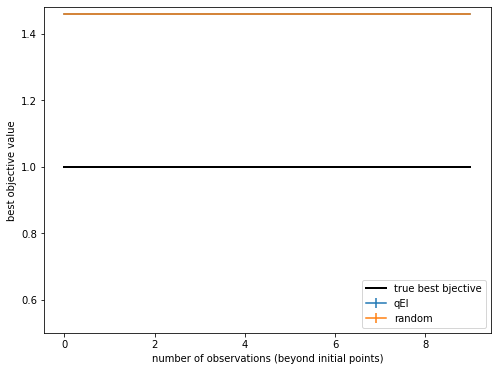

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

BATCH_SIZE = 3
num_qubits = 2
MAX_OP_NODES = 2

encoding_length = (num_qubits + 1) * MAX_OP_NODES
bounds = torch.tensor([[-0.1] * encoding_length, [1.0] * encoding_length], device=device, dtype=dtype)

N_TRIALS = 1
N_BATCH = 3
MC_SAMPLES = 2048

qnnbo = QNN_BO(
    num_qubits = num_qubits,
    MAX_OP_NODES = MAX_OP_NODES,
    N_TRIALS = N_TRIALS,
    N_BATCH = N_BATCH,
    BATCH_SIZE = BATCH_SIZE,
    MC_SAMPLES = MC_SAMPLES
)

best_observed_all_ei, best_random_all = qnnbo.optimize(bounds=bounds)

#qnnbo.plot(best_observed_all_ei, best_observed_all_nei, best_random_all)
to_plot = {'qEI': best_observed_all_ei,'random': best_random_all}
qnnbo.plot(to_plot)